In [1]:
import os
from dataclasses import dataclass, field
from typing import Any, Generator, Optional, Tuple, Union

import numpy as np
import torch
from torchtyping import TensorType
import tqdm.notebook as tqdm
from modelling_sae import *

In [2]:
def overcomplete_gram_schmidt(feats: TensorType["n_ground_truth_components_", "activation_dim_"], alpha=0.0001) -> TensorType["n_ground_truth_components_", "activation_dim_"]:
    orth_matrix = feats @ feats.T
    orth_matrix -= torch.eye(orth_matrix.shape[0], device=orth_matrix.device)
    # orth_matrix = torch.tril(orth_matrix, diagonal=-1)
    feats -= alpha * (orth_matrix @ feats)
    return normalize_dict(feats)

def approx_overcomplete_gram_schmidt(feats: TensorType["n_ground_truth_components_", "activation_dim_"], alpha=1, n_ortho=None) -> TensorType["n_ground_truth_components_", "activation_dim_"]:
    if n_ortho is None:
        n_ortho = feats.shape[1]
    rand_idxs = torch.randperm(feats.shape[0])[:n_ortho]
    feat_subset = feats[rand_idxs]
    orth_matrix = feat_subset @ feat_subset.T
    orth_matrix -= torch.eye(orth_matrix.shape[0], device=orth_matrix.device)
    # orth_matrix = torch.tril(orth_matrix, diagonal=-1)
    orth_matrix = orth_matrix.clamp(min=0).pow(2)
    feat_subset -= alpha * (orth_matrix @ feat_subset)
    
    output = feats.clone()
    output[rand_idxs] = feat_subset

    return output

def reinitialize_similar_features(feats: TensorType["n_ground_truth_components_", "activation_dim_"], thresh=0.9, n_ortho=None) -> TensorType["n_ground_truth_components_", "activation_dim_"]:
    if n_ortho is None:
        n_ortho = feats.shape[0]
    rand_idxs = torch.randperm(feats.shape[0])[:n_ortho]
    feat_subset = feats[rand_idxs]
    
    similarities = feat_subset @ feat_subset.T
    similarities = torch.tril(similarities, diagonal=-1)

    reinit_mask = similarities > thresh

    n_reinit = 0

    for i in range(n_ortho):
        if reinit_mask[i].sum() > 0:
            feat_subset[i] = torch.randn_like(feat_subset[i])
            n_reinit += 1

    # print(f"Reinitialized {n_reinit} features")

    output = feats.clone()
    output[rand_idxs] = feat_subset

    return output

In [3]:
512 * 4

2048

In [4]:
xs = torch.randn(512, 512)
xs /= xs.pow(2).sum(dim=-1).sqrt().unsqueeze(-1)

xs = torch.stack([xs] * 4).transpose(0, 1).reshape(-1, 512)

print(xs @ xs.T)

print(xs.shape[0])

xs_ = reinitialize_similar_features(xs.clone(), thresh=0.9)

print(xs @ xs_.T)

tensor([[1.0000, 1.0000, 1.0000,  ..., 0.0607, 0.0607, 0.0607],
        [1.0000, 1.0000, 1.0000,  ..., 0.0607, 0.0607, 0.0607],
        [1.0000, 1.0000, 1.0000,  ..., 0.0607, 0.0607, 0.0607],
        ...,
        [0.0607, 0.0607, 0.0607,  ..., 1.0000, 1.0000, 1.0000],
        [0.0607, 0.0607, 0.0607,  ..., 1.0000, 1.0000, 1.0000],
        [0.0607, 0.0607, 0.0607,  ..., 1.0000, 1.0000, 1.0000]])
2048
tensor([[-0.9404, -1.7046,  0.3309,  ...,  0.3591,  0.0607, -0.1310],
        [-0.9404, -1.7046,  0.3309,  ...,  0.3591,  0.0607, -0.1310],
        [-0.9404, -1.7046,  0.3309,  ...,  0.3591,  0.0607, -0.1310],
        ...,
        [-1.0597, -0.7655,  0.4472,  ...,  0.1545,  1.0000, -1.8636],
        [-1.0597, -0.7655,  0.4472,  ...,  0.1545,  1.0000, -1.8636],
        [-1.0597, -0.7655,  0.4472,  ...,  0.1545,  1.0000, -1.8636]])


In [5]:
n_ground_truth_components_, activation_dim_, dataset_size_ = (
    None,
    None,
    None,
) # type: Tuple[None, None, None]


@dataclass
class RandomDatasetGenerator(Generator):
    activation_dim: int
    n_ground_truth_components: int
    batch_size: int
    feature_num_nonzero: int
    feature_prob_decay: float
    correlated: bool
    device: Union[torch.device, str]

    frac_nonzero: float = field(init=False)
    decay: TensorType["n_ground_truth_components"] = field(init=False)
    feats: TensorType["n_ground_truth_components", "activation_dim"] = field(init=False)
    feat_scales: Optional[TensorType["n_ground_truth_components"]] = None
    corr_matrix: Optional[TensorType["n_ground_truth_components", "n_ground_truth_components"]] = field(init=False)
    component_probs: Optional[TensorType["n_ground_truth_components"]] = field(init=False)

    def __post_init__(self):
        self.frac_nonzero = self.feature_num_nonzero / self.n_ground_truth_components

        # Define the probabilities of each component being included in the data
        self.decay = torch.tensor([self.feature_prob_decay**i for i in range(self.n_ground_truth_components)]).to(
            self.device
        )  # FIXME: 1 / i

        if self.correlated:
            self.corr_matrix = generate_corr_matrix(self.n_ground_truth_components, device=self.device)
        else:
            self.component_probs = self.decay * self.frac_nonzero  # Only if non-correlated
        self.feats = generate_rand_feats(
            self.activation_dim,
            self.n_ground_truth_components,
            ortho=True,
            device=self.device,
        )
        self.feat_scales = torch.rand(self.n_ground_truth_components, device=self.device) * 10
        self.t_type = torch.float32

    def send(self, ignored_arg: Any) -> TensorType["dataset_size_", "activation_dim_"]:
        if self.correlated:
            _, _, data = generate_correlated_dataset(
                self.n_ground_truth_components,
                self.batch_size,
                self.corr_matrix,
                self.feats,
                self.feat_scales,
                self.frac_nonzero,
                self.decay,
                self.device,
            )
        else:
            _, _, data = generate_rand_dataset(
                self.n_ground_truth_components,
                self.batch_size,
                self.component_probs,
                self.feats,
                self.feat_scales,
                self.device,
            )
        return data.to(self.t_type)

    def throw(self, type: Any = None, value: Any = None, traceback: Any = None) -> None:
        raise StopIteration

def generate_rand_dataset(
    n_ground_truth_components: int,  #
    dataset_size: int,
    feature_probs: TensorType["n_ground_truth_components_"],
    feats: TensorType["n_ground_truth_components_", "activation_dim_"],
    feat_scales: TensorType["n_ground_truth_components_"],
    device: Union[torch.device, str],
) -> Tuple[
    TensorType["n_ground_truth_components_", "activation_dim_"],
    TensorType["dataset_size_", "n_ground_truth_components_"],
    TensorType["dataset_size_", "activation_dim_"],
]:
    dataset_thresh = torch.rand(dataset_size, n_ground_truth_components, device=device)
    dataset_values = torch.randn(dataset_size, n_ground_truth_components, device=device).pow(2) + feat_scales.unsqueeze(0)

    data_zero = torch.zeros_like(dataset_thresh, device=device)

    dataset_codes = torch.where(
        dataset_thresh <= feature_probs,
        dataset_values,
        data_zero,
    )  # dim: dataset_size x n_ground_truth_components

    # Multiply by a 2D random matrix of feature strengths
    feature_strengths = torch.rand((dataset_size, n_ground_truth_components), device=device)
    dataset = (dataset_codes * feature_strengths) @ feats

    # dataset = dataset_codes @ feats

    return feats, dataset_codes, dataset


def generate_correlated_dataset(
    n_ground_truth_components: int,
    dataset_size: int,
    corr_matrix: TensorType["n_ground_truth_components_", "n_ground_truth_components_"],
    feats: TensorType["n_ground_truth_components_", "activation_dim_"],
    feat_scales: TensorType["n_ground_truth_components_"],
    frac_nonzero: float,
    decay: TensorType["n_ground_truth_components_"],
    device: Union[torch.device, str],
) -> Tuple[
    TensorType["n_ground_truth_components_", "activation_dim_"],
    TensorType["dataset_size_", "n_ground_truth_components_"],
    TensorType["dataset_size_", "activation_dim_"],
]:
    # Get a correlated gaussian sample
    mvn = torch.distributions.MultivariateNormal(
        loc=torch.zeros(n_ground_truth_components, device=device),
        covariance_matrix=corr_matrix,
    )
    corr_thresh = mvn.sample()

    # Take the CDF of that sample.
    normal = torch.distributions.Normal(torch.tensor([0.0], device=device), torch.tensor([1.0], device=device))
    cdf = normal.cdf(corr_thresh.squeeze())

    # Decay it
    component_probs = cdf * decay

    # Scale it to get the right % of nonzeros
    mean_prob = torch.mean(component_probs)
    scaler = frac_nonzero / mean_prob
    component_probs *= scaler
    # So np.isclose(np.mean(component_probs), frac_nonzero) will be True

    # Generate sparse correlated codes
    dataset_thresh = torch.rand(dataset_size, n_ground_truth_components, device=device)
    dataset_values = torch.randn(dataset_size, n_ground_truth_components, device=device).pow(2) + feat_scales.unsqueeze(0)

    data_zero = torch.zeros_like(corr_thresh, device=device)
    dataset_codes = torch.where(
        dataset_thresh <= component_probs,
        dataset_values,
        data_zero,
    )
    # Ensure there are no datapoints w/ 0 features
    zero_sample_index = (dataset_codes.count_nonzero(dim=1) == 0).nonzero()[:, 0]
    random_index = torch.randint(low=0, high=n_ground_truth_components, size=(zero_sample_index.shape[0],)).to(
        dataset_codes.device
    )
    dataset_codes[zero_sample_index, random_index] = 1.0

    # Multiply by a 2D random matrix of feature strengths
    feature_strengths = torch.rand((dataset_size, n_ground_truth_components), device=device)
    dataset = (dataset_codes * feature_strengths) @ feats

    return feats, dataset_codes, dataset


def generate_rand_feats(
    feat_dim: int,
    num_feats: int,
    device: Union[torch.device, str],
    ortho: bool = False,
) -> TensorType["n_ground_truth_components_", "activation_dim_"]:
    data_path = os.path.join(os.getcwd(), "data")
    data_filename = os.path.join(data_path, f"feats_{feat_dim}_{num_feats}.npy")

    with torch.no_grad():
        feats = torch.randn(num_feats, feat_dim, device=device)
        feats = normalize_dict(feats)

        if ortho:
            for _ in tqdm.tqdm(range(10_000)):
                feats = approx_overcomplete_gram_schmidt(feats, alpha=0.01)
                feats = normalize_dict(feats)
    
    print(feats @ feats.T)

    return feats


def generate_corr_matrix(
    num_feats: int, device: Union[torch.device, str]
) -> TensorType["n_ground_truth_components_", "n_ground_truth_components_"]:
    corr_mat_path = os.path.join(os.getcwd(), "data")
    corr_mat_filename = os.path.join(corr_mat_path, f"corr_mat_{num_feats}.npy")

    # Create a correlation matrix
    corr_matrix = np.random.rand(num_feats, num_feats)
    corr_matrix = (corr_matrix + corr_matrix.T) / 2
    min_eig = np.min(np.real(np.linalg.eigvals(corr_matrix)))
    if min_eig < 0:
        corr_matrix -= 1.001 * min_eig * np.eye(corr_matrix.shape[0], corr_matrix.shape[1])

    corr_matrix_tensor = torch.from_numpy(corr_matrix).to(device).float()

    return corr_matrix_tensor

In [6]:
from modelling_sae import *

In [7]:
# l1_alphas = np.logspace(-2, 1, 100)
n_feats = 512 * 6
d_model = 512
device = "cuda:0"

generator = RandomDatasetGenerator(
    activation_dim=d_model,
    n_ground_truth_components=n_feats,
    batch_size=1024,
    feature_num_nonzero=10,
    feature_prob_decay=1, # final feat has 10% the probability of the first
    correlated=False,
    device=device,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor([[ 1.0000, -0.0405, -0.0057,  ..., -0.0047, -0.0597, -0.0103],
        [-0.0405,  1.0000, -0.0471,  ...,  0.0124,  0.0658,  0.0174],
        [-0.0057, -0.0471,  1.0000,  ...,  0.0181, -0.0222,  0.0581],
        ...,
        [-0.0047,  0.0124,  0.0181,  ...,  1.0000,  0.0729,  0.0099],
        [-0.0597,  0.0658, -0.0222,  ...,  0.0729,  1.0000, -0.0427],
        [-0.0103,  0.0174,  0.0581,  ...,  0.0099, -0.0427,  1.0000]],
       device='cuda:0')


In [8]:
class NNOrthoICA(torch.nn.Module):
    def __init__(self, d_in, d_hidden, alpha, n_ortho=None):
        super().__init__()
        initial_matrix = torch.randn(d_hidden, d_in)
        initial_matrix = normalize_dict(initial_matrix)
        self.embed = torch.nn.Parameter(initial_matrix.clone())

        self.alpha = alpha
        self.n_ortho = n_ortho
    
    def forward(self, x):
        embed = normalize_dict(self.embed)
        # embed = approx_overcomplete_gram_schmidt(self.embed, alpha=self.alpha, n_ortho=self.n_ortho)
        # mean center the batch
        x_mean = x.mean(dim=0)
        x_centered = x - x_mean

        # project the batch onto the dictionary
        h = torch.einsum('ij,bj->bi', embed, x_centered)
        # h = torch.nn.functional.relu(h)
        
        kurtosis = (h.pow(4).mean(dim=0) / h.pow(2).mean(dim=0).pow(2)).mean()

        # generate batch_size randints
        # ortho_idxs = torch.randint(0, embed.shape[0], (x.shape[0], self.n_ortho))
        # ortho = embed[ortho_idxs]
        # ortho_matrix = torch.einsum('bij,bkj->bik', ortho, ortho)
        # ortho_loss = (ortho_matrix - torch.eye(self.n_ortho, device="cuda").unsqueeze(0)).clamp(min=0).mean()

        # z = torch.randn_like(x)
        # h_z = torch.einsum('ij,bj->bi', self.embed, z)
        # h_z = torch.nn.functional.relu(h_z)
        # z_hat = torch.einsum('ij,bi->bj', self.embed, h_z)
        # ortho_loss = (z - z_hat).pow(2).mean()

        x_hat = torch.einsum('ij,bi->bj', embed, h)
        ortho_loss = (x_centered - x_hat).pow(2).mean()

        return ortho_loss - self.alpha * kurtosis, h
    
    def project(self, orthoganalize=False):
        with torch.no_grad():
            self.embed.data = normalize_dict(self.embed.data)
            # self.embed.data = approx_overcomplete_gram_schmidt(self.embed.data, alpha=self.alpha, n_ortho=self.n_ortho)
            # self.embed.data = normalize_dict(self.embed.data)
            if orthoganalize:
                self.embed.data = reinitialize_similar_features(self.embed.data, thresh=0.99, n_ortho=None)
            # if orthoganalize:
            #     for _ in range(100):
            #         self.embed.data = approx_overcomplete_gram_schmidt(self.embed.data, alpha=0.5, n_ortho=self.n_ortho)
            #         self.embed.data = normalize_dict(self.embed.data)

    @property
    def dictionary(self):
        return normalize_dict(self.embed).detach()

class SAE(torch.nn.Module):
    def __init__(self, d_in, d_hidden, alpha):
        super().__init__()
        initial_matrix = torch.randn(d_hidden, d_in)
        initial_matrix = normalize_dict(initial_matrix)
        self.embed = torch.nn.Parameter(initial_matrix.clone())
        self.unembed = torch.nn.Parameter(initial_matrix.clone())
        self.in_bias = torch.nn.Parameter(torch.zeros(d_hidden))
        self.out_bias = torch.nn.Parameter(torch.zeros(d_in))

        self.alpha = alpha
    
    def forward(self, x):
        h = torch.einsum('ij,bj->bi', self.embed, x) + self.in_bias
        h = torch.nn.functional.relu(h)

        unembed = normalize_dict(self.unembed)

        x_hat = torch.einsum('ij,bi->bj', unembed, h) + self.out_bias

        mse = (x - x_hat).pow(2).mean()
        sparsity = h.abs().mean()

        return mse + self.alpha * sparsity, h

    def project(self, orthoganalize=None):
        with torch.no_grad():
            self.unembed.data = normalize_dict(self.unembed.data)
            # self.unembed.data = approx_overcomplete_gram_schmidt(self.unembed.data, alpha=0.1, n_ortho=None)
            # self.unembed.data = normalize_dict(self.unembed.data)
            # if orthoganalize:
            #     for _ in range(100):
            #         self.unembed.data = approx_overcomplete_gram_schmidt(self.unembed.data, alpha=self.alpha, n_ortho=self.n_ortho)
            #         self.unembed.data = normalize_dict(self.unembed.data)
    
    @property
    def dictionary(self):
        return normalize_dict(self.unembed).detach()

In [9]:
from matplotlib import pyplot as plt

def calc_mean_max_cosine_similarity(model, generator):
    model_feat_dict = model.dictionary
    data_feat_dict = normalize_dict(generator.feats)

    cosines = torch.einsum('ij,kj->ik', model_feat_dict, data_feat_dict)
    max_cosines = cosines.max(dim=-1).values
    # print(max_cosines.shape)
    dict_representation = max_cosines.mean().item()
    max_cosines = cosines.max(dim=0).values
    # print(max_cosines.shape)
    gt_representation = max_cosines.mean().item()
    return dict_representation, gt_representation

def get_metrics(models, generator, n_iters=10):
    data_mean_mse = 0
    model_mean_mse = [0 for _ in models]
    model_sparsity = [0 for _ in models]
    model_mmcs = [calc_mean_max_cosine_similarity(model, generator) for model in models]

    for _ in range(n_iters):
        data = generator.send(None)

        batch_mean = torch.mean(data, dim=0)

        data_mean_mse += torch.nn.functional.mse_loss(data, batch_mean.unsqueeze(0), reduction='mean').item()

        for i, model in enumerate(models):
            with torch.no_grad():
                _, mse, _, h, x_hat = model(data)
                model_mean_mse[i] += mse.item()
                model_sparsity[i] += (h > 0).float().sum(dim=-1).mean().item()
    
    data_mean_mse /= n_iters
    model_mean_mse = [m / n_iters for m in model_mean_mse]
    model_sparsity = [s / n_iters for s in model_sparsity]

    model_scaled_mse = [m / data_mean_mse for m in model_mean_mse]

    return model_scaled_mse, model_sparsity, model_mmcs

def get_metrics_ortho(models, generator, n_iters=10):
    model_mmcs = [calc_mean_max_cosine_similarity(model, generator) for model in models]
    model_dict_rep = [m[0] for m in model_mmcs]
    model_gt_rep = [m[1] for m in model_mmcs]
    model_sparsity = [0 for _ in models]
    model_kurtosis = [0 for _ in models]
    gt_kurtosis = 0

    for _ in range(n_iters):
        data = generator.send(None)
        data_mean = data.mean(dim=0)

        h = (normalize_dict(generator.feats) @ (data - data_mean.unsqueeze(0)).T).T
        h = torch.nn.functional.relu(h)
        gt_kurtosis += (h.pow(4).mean(dim=0) / h.abs().pow(2).mean(dim=0).pow(2)).mean().item()

        for i, model in enumerate(models):
            with torch.no_grad():
                _, h = model(data)
                model_sparsity[i] += h.abs().mean().item()

                h = (model.dictionary @ (data - data.mean(dim=0).unsqueeze(0)).T).T
                h = torch.nn.functional.relu(h)

                model_kurtosis[i] += (h.pow(4).mean(dim=0) / h.abs().pow(2).mean(dim=0).pow(2)).mean().item()
    
    model_sparsity = [s / n_iters for s in model_sparsity]
    model_kurtosis = [k / n_iters for k in model_kurtosis]
    gt_kurtosis /= n_iters

    return model_dict_rep, model_gt_rep, model_sparsity, model_kurtosis, gt_kurtosis

def plot_ensemble(model_scaled_mse, model_sparsity, model_mmcs):
    plt.scatter(model_sparsity, model_scaled_mse, c=model_mmcs, cmap='viridis')
    plt.xlabel('Sparsity')
    plt.ylabel('Scaled MSE')
    plt.colorbar(label='Mean Max Cosine Similarity')
    plt.show()

def plot_ensemble_ortho(model_class_names, model_metrics, model_alphas):
    # plot alpha vs mmcs and sparsity (different scales)
    fig, ax1 = plt.subplots()

    for class_name, metrics, alphas in zip(model_class_names, model_metrics, model_alphas):
        for metric_name, metric in metrics.items():
            ax1.plot(alphas, metric, label=f'{class_name} {metric_name}')
    
    # ax1.set_ylim(0, 1)
    ax1.set_xscale('log')

    plt.legend()
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

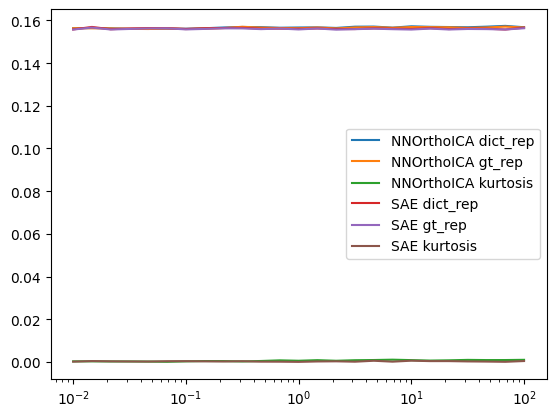

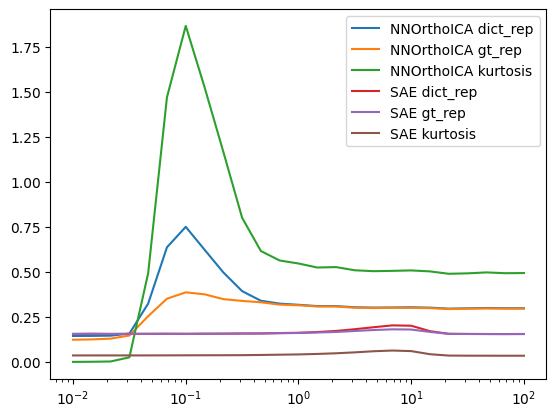

In [10]:
models = [
    NNOrthoICA(d_model, n_feats, alpha).to(device)
    for alpha in [10**x for x in np.linspace(-2, 2, 25)]
]

models += [
    SAE(d_model, n_feats, alpha).to(device)
    for alpha in [10**x for x in np.linspace(-2, 2, 25)]
]

optimizers = [
    torch.optim.Adam(model.parameters(), lr=1e-3)
    for model in models
]

num_steps = 10_000

metrics = []

for step in tqdm.tqdm(range(num_steps)):
    data = generator.send(None)

    for model, optimizer in zip(models, optimizers):
        optimizer.zero_grad()
        loss, _ = model(data)
        loss.backward()
        optimizer.step()
        model.project(orthoganalize=step % 500 == 0)

    if step % 500 == 0:
        model_dict_rep, model_gt_rep, model_sparsity, model_kurtosis, gt_kurtosis = get_metrics_ortho(models, generator)
        metrics.append({"dict_rep": model_dict_rep, "gt_rep": model_gt_rep})

        model_class_names = ['NNOrthoICA', 'SAE']

        ortho_dict_rep = model_dict_rep[:len(models) // 2]
        ortho_gt_rep = model_gt_rep[:len(models) // 2]
        ortho_kurtosis = model_kurtosis[:len(models) // 2]

        sae_dict_rep = model_dict_rep[len(models) // 2:]
        sae_gt_rep = model_gt_rep[len(models) // 2:]
        sae_kurtosis = model_kurtosis[len(models) // 2:]

        all = ortho_kurtosis + sae_kurtosis

        ortho_kurtosis = [o - min(all) for o in ortho_kurtosis]
        sae_kurtosis = [s - min(all) for s in sae_kurtosis]
        gt_kurtosis = gt_kurtosis - min(all)

        all = ortho_kurtosis + sae_kurtosis

        ortho_kurtosis = [o / gt_kurtosis for o in ortho_kurtosis]
        sae_kurtosis = [s / gt_kurtosis for s in sae_kurtosis]

        ortho_metrics = {
            'dict_rep': ortho_dict_rep,
            'gt_rep': ortho_gt_rep,
            'kurtosis': ortho_kurtosis,
        }

        sae_metrics = {
            'dict_rep': sae_dict_rep,
            'gt_rep': sae_gt_rep,
            'kurtosis': sae_kurtosis,
        }

        model_metrics = [ortho_metrics, sae_metrics]

        model_alphas = [
            [model.alpha for model in models[:len(models) // 2]],
            [model.alpha for model in models[len(models) // 2:]],
        ]

        plot_ensemble_ortho(model_class_names, model_metrics, model_alphas)

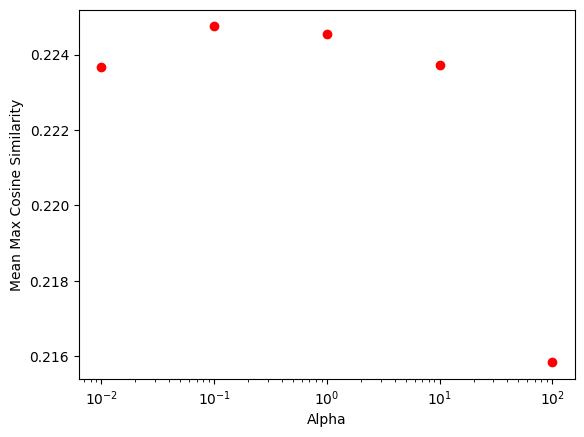

In [ ]:
model_mmcs = get_metrics_ortho(models, generator)
metrics.append({"mmcs": model_mmcs})
plot_ensemble_ortho(model_mmcs, [model.alpha for model in models])

In [ ]:
x = models[6].dictionary
(x @ x.T - torch.eye(x.shape[0]).cuda()).max()

IndexError: list index out of range

In [ ]:
x = models[6].dictionary
feats = normalize_dict(generator.feats)

cosines = torch.einsum('ij,kj->ik', x, feats)
max_cosines = cosines.max(dim=-1).values
way_1 = max_cosines.mean().item()

max_cosines = cosines.max(dim=0).values
way_2 = max_cosines.mean().item()

way_1, way_2

In [ ]:
max_cosines = cosines.max(dim=0).values

from matplotlib.ticker import PercentFormatter

# histogram of max cosines

max_cosines_np = max_cosines.cpu().numpy()

plt.hist(max_cosines_np, bins=10, weights=np.ones_like(max_cosines_np) / len(max_cosines_np), log=True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("GT representation in dict")

In [ ]:
max_cosines = cosines.max(dim=-1).values

from matplotlib.ticker import PercentFormatter

# histogram of max cosines

max_cosines_np = max_cosines.cpu().numpy()

plt.hist(max_cosines_np, bins=10, weights=np.ones_like(max_cosines_np) / len(max_cosines_np), log=True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Dict representation in GT")

In [ ]:
import torch
import tqdm

In [ ]:
x = torch.randn(32768, 1024, device="cuda")
x.requires_grad = True

opt = torch.optim.Adam([x], lr=1e-3)

for _ in tqdm.tqdm(range(10_000)):
    with torch.no_grad():
        x.data /= x.data.norm(dim=1).unsqueeze(1)
    # r = torch.randn(256, 32768, device="cuda")
    # y = r @ x
    random_idx = torch.randperm(32768, device="cuda")[:4096]
    y = x[random_idx]
    loss = (y @ y.T - torch.eye(4096, device="cuda")).pow(2).mean()
    loss.backward()
    opt.step()
    opt.zero_grad()

100%|██████████| 10000/10000 [01:48<00:00, 92.28it/s]


In [ ]:
with torch.no_grad():
    x.data /= x.data.norm(dim=1).unsqueeze(1)

(x @ x.T).shape
(x @ x.T).max()

NameError: name 'torch' is not defined